**Цели исследования:** полный анализ игры после внесения изменений и  определение влияния этих изменений на вовлеченность пользователей в игру.

Поставленные нашей командой **цели** достигаются путем выполнения следующих **задач:**

1. Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение. 
2. Выяснить, как часто пользователи начинают обучение после того, как они выбрали уровень сложности. 
3. Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 



# Задача 1
## Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение. 

На этапе сбора и обработки данных были отобраны *общие этапы для 2-х групп* (проходивших и не проходивших обучение) 
для сравнения времени их прохождения с целью выявить сокращает ли обучение время прохождение этапов

**Общие этапы:**

Для группы пользователей, проходивших обучение 1-й этап игры - 
время между регистрацией и началом обучения

Для группы пользователей, не проходивших обучение 1-й этап игры - 
время между регистрацией и выбором уровня сложности
                                                 
                                               2-й этап - время между выбором уровня сложности обучения и пакетом бесплатных                                                     
                                               вопросов 
                                                  
                                               3-й этап - время между выбором пакета бесплатных вопросов и оплаты пакета 
                                               платных вопросов


In [1]:
#импортируем библиотеки
import pandas as pd
#избавляемся от ненужных предупреждений
import warnings; warnings.simplefilter('ignore') 
#читаем и записываем данные о действиях пользователей в датафрейм
events=pd.read_csv('7_4_Events.csv')
conditions= events[(events.event_type=='registration')&(events.start_time>='2018-01-01')&(events.start_time<'2019-01-01')]
cond=conditions.user_id.to_list()
#выводим пользователей, зарегистрированных в 2018 году
#В дальнейшем вся обработка и анализ данных будут осуществляться только на пользователях, зарегистрированных в 2018 году
events_18=events[events.user_id.isin(cond)]
#приводим к рабочему формату времени
events_18.start_time=pd.to_datetime(events_18.start_time, format='%Y-%m-%d %H:%M:%S')
#читаем и записываем данные о совершенных покупках пользователей в датафрейм
purchases=pd.read_csv('purchase.csv')
#выбираем оплаты совершенные исключительно пользователями, зарегистрированными в 2018 году
purchases_18=purchases[purchases.user_id.isin(cond)] 
purchases_18.event_datetime=pd.to_datetime(purchases_18.event_datetime, format='%Y-%m-%d %H:%M:%S')
#записываем id пользователей, имеющих tutorial_finish, т.е. пользователей, прошедших обучение(закончивших его)
tutorial_finish=events_18[events_18.event_type=='tutorial_finish'].user_id.unique()
#выводим данные по пользователям с пройденным (и законченным) этапом обучения
tutor_finish=events_18[events_18.user_id.isin(tutorial_finish)].reset_index(drop=True)
tutor_finish.head()

,id,event_type,selected_level,start_time,tutorial_id,user_id
0,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
1,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
2,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
3,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836
4,80315,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836


In [2]:
#выделяем этап регистрации пользователей для дальнейшего определения времени их регистрации
reg_tutor_finish=tutor_finish[tutor_finish.event_type=='registration'].rename(columns={'start_time':'reg_time'})
#проверяем среднее число  регистраций на 1 пользователя (проверяем наличие технической ошибки)
check1=reg_tutor_finish.user_id.value_counts().mean()
#выделяем этап начала обучения для определения времени этого этапа, сортирем по времени и выбираем время первого обучения
#Т.к. количество обучений м.б. несколько, выделяем только первое обучение
start_tutor_finish=tutor_finish[tutor_finish.event_type=='tutorial_start'].rename(columns={'start_time':'tut_start_time'}).sort_values('tut_start_time').drop_duplicates('user_id')
#объединяем данные пользователей с выделенным этапом их регистрации с данными с выделенным этапом начала их обучения
merge_finished_df1=reg_tutor_finish.merge(start_tutor_finish, on='user_id', how='inner')
#выделяем из объединенной таблицы только нужные нам данные
merge_finished_df1=merge_finished_df1[['user_id', 'reg_time', 'tut_start_time']]
#определяем промежуток времени между этапом регистрации и этапом начала обучения
merge_finished_df1['timedelta']=merge_finished_df1['tut_start_time']-merge_finished_df1['reg_time']
print('\033[1m'+'Время между регистрацией и началом обучения у пользователей, прошедших обучения хотя бы 1 раз:\n\n'+'\033[0m', merge_finished_df1.timedelta.describe())


Время между регистрацией и началом обучения у пользователей, прошедших обучения хотя бы 1 раз:

 count                     10250
mean     0 days 04:31:04.938146
std      0 days 04:11:24.828137
min             0 days 00:00:34
25%      0 days 01:17:55.500000
50%             0 days 03:13:48
75%      0 days 06:37:27.750000
max             1 days 16:03:46
Name: timedelta, dtype: object


In [3]:
#выводим этап выбора уровня сложности 
level_choice_finish=tutor_finish[(tutor_finish.event_type=='level_choice')].rename(columns={'start_time':'level_choice_time'})
#выводим этап выбора пакета бесплатных вопросов 
pack_choice_finish=tutor_finish[(tutor_finish.event_type=='pack_choice')].rename(columns={'start_time':'pack_choice_time'})
#проверяем среднее число уровней сложности на 1 пользователя
check1=level_choice_finish.user_id.value_counts().mean()
#проверяем среднее число бесплатных пакетов на 1 пользователя 
check2=pack_choice_finish.user_id.value_counts().mean()
#объединяем этап выбора уровня сложности с этапом выбора пакета бесплатных вопросов
merge_finished_df2=level_choice_finish.merge(pack_choice_finish, on='user_id', how='inner')
#выделяем из объединенной таблицы  только нужные нам данные
merge_finished_df2=merge_finished_df2[['user_id', 'level_choice_time', 'pack_choice_time']]
#определяем промежуток времени между этапом выбора уровня сложности и этапом выбора пакета бесплатных вопросов
merge_finished_df2['timedelta']=merge_finished_df2['pack_choice_time']-merge_finished_df2['level_choice_time']
print('\033[1m'+'Время между выбором сложности обучения и пакетом бесплатных вопросов у пользователей прошедших обучение:\n\n'+'\033[0m',merge_finished_df2.timedelta.describe())


Время между выбором сложности обучения и пакетом бесплатных вопросов у пользователей прошедших обучение:

 count                      5176
mean     0 days 00:05:18.146058
std      0 days 00:02:44.449118
min             0 days 00:00:19
25%             0 days 00:03:05
50%             0 days 00:04:58
75%             0 days 00:07:11
max             0 days 00:15:48
Name: timedelta, dtype: object


In [4]:
#выделяем оплаты пользователей, прошедших обучение
purchase_finish=purchases_18[purchases_18.user_id.isin(tutorial_finish)].rename(columns={'event_datetime':'purchase_time'})
#объединяем этап выбора пакета бесплатных вопросов с этапом выбора пакета платных вопросов
merge_finished_df3=pack_choice_finish.merge(purchase_finish, on='user_id', how='inner')
#выделяем из объединенной таблицы только нужные нам данные
merge_finished_df3=merge_finished_df3[['user_id', 'pack_choice_time', 'purchase_time']] 
#определяем промежуток времени между этапом выбора пакета бесплатных вопросов и этапом выбора пакета платных вопросов
merge_finished_df3['timedelta']=merge_finished_df3['purchase_time']-merge_finished_df3['pack_choice_time']
print('\033[1m'+'Время между выбором пакета бесплатных вопросов и оплаты пакета платных вопросов у пользователей прошедших обучение:\n\n'+'\033[0m', merge_finished_df3.timedelta.describe())


Время между выбором пакета бесплатных вопросов и оплаты пакета платных вопросов у пользователей прошедших обучение:

 count                      1447
mean     3 days 17:17:59.641326
std      2 days 04:31:59.804658
min             0 days 00:44:50
25%      1 days 21:16:05.500000
50%             3 days 12:15:56
75%      5 days 08:53:44.500000
max            10 days 18:33:59
Name: timedelta, dtype: object


In [5]:
#Аналогичные действия осуществляем с пользователями не имеющими этап обучения tutorial_start
#Т.к.некоторые пользователи проходят обучение несколько раз, у них имеется несколько данных начала время обучения, поэтому 
#убираем дубликаты пользователей, которые проходили обучение несколько раз и т.о. выбираем время первого обучения
tutor_started=events_18[events_18.event_type=='tutorial_start'].sort_values('start_time').drop_duplicates('user_id')
tutor_started_fix=tutor_started.user_id.unique()
all_users=events_18.user_id.unique()
set_all_users=set(all_users)
not_started_tutorial=set_all_users.difference(tutor_started_fix)
not_started_tutor=events_18[events_18.user_id.isin(not_started_tutorial)]
reg_not_started_tutor=not_started_tutor[not_started_tutor.event_type=='registration'].rename(columns={'start_time':'reg_time'})
level_choice_not_started=not_started_tutor[not_started_tutor.event_type=='level_choice'].rename(columns={'start_time':'level_choice_time'})
merge_not_started_df1=reg_not_started_tutor.merge(level_choice_not_started, on='user_id', how='inner')
merge_not_started_df1=merge_not_started_df1[['user_id', 'reg_time', 'level_choice_time']]
merge_not_started_df1['timedelta']=merge_not_started_df1['level_choice_time']-merge_not_started_df1['reg_time']
print('\033[1m'+'Время между регистрацией и выбором уровня сложности обучения у пользователей НЕ проходивших обучение:\n\n'+'\033[0m', merge_not_started_df1.timedelta.describe())


Время между регистрацией и выбором уровня сложности обучения у пользователей НЕ проходивших обучение:

 count                        98
mean     0 days 05:15:33.122448
std      0 days 03:41:00.594664
min             0 days 00:09:26
25%      0 days 02:15:28.500000
50%      0 days 04:56:05.500000
75%             0 days 08:24:01
max             0 days 18:34:21
Name: timedelta, dtype: object


In [6]:
pack_not_started=not_started_tutor[not_started_tutor.event_type=='pack_choice'].rename(columns={'start_time':'pack_choice_time'})
check5=pack_not_started.user_id.value_counts().mean()
merge_not_started_df2=level_choice_not_started.merge(pack_not_started, on='user_id', how='inner')
merge_not_started_df2=merge_not_started_df2[['user_id', 'level_choice_time', 'pack_choice_time']]
merge_not_started_df2['timedelta']=merge_not_started_df2['pack_choice_time']-merge_not_started_df2['level_choice_time']
print('\033[1m'+'Время между выбором уровня сложности обучения и пакетом бесплатных вопросов  у пользователей НЕ прошедших обучение:\n\n'+'\033[0m', merge_not_started_df2.timedelta.describe())


Время между выбором уровня сложности обучения и пакетом бесплатных вопросов  у пользователей НЕ прошедших обучение:

 count                        74
mean     0 days 00:05:23.824324
std      0 days 00:03:01.230146
min             0 days 00:00:48
25%      0 days 00:03:09.750000
50%      0 days 00:04:46.500000
75%      0 days 00:07:11.250000
max             0 days 00:13:32
Name: timedelta, dtype: object


In [7]:
purchase_not_started=purchases_18[purchases_18.user_id.isin(not_started_tutorial)].rename(columns={'event_datetime':'purchase_time'})
check6=purchase_not_started.user_id.value_counts().mean( )
merge_not_started_df3=purchase_not_started.merge(pack_not_started, on='user_id', how='inner')
merge_not_started_df3=merge_not_started_df3[['user_id', 'pack_choice_time', 'purchase_time']]
merge_not_started_df3['timedelta']=merge_not_started_df3['purchase_time']-merge_not_started_df3['pack_choice_time']
print('\033[1m'+'Время между выбором пакета бесплатных вопросов и оплаты пакета платных вопросов у пользователей НЕ прошедших обучение:\n\n'+'\033[0m', merge_not_started_df3.timedelta.describe())



Время между выбором пакета бесплатных вопросов и оплаты пакета платных вопросов у пользователей НЕ прошедших обучение:

 count                        22
mean     4 days 04:49:33.590909
std      2 days 04:58:40.602573
min             0 days 09:35:48
25%             2 days 15:49:22
50%             4 days 04:38:42
75%      5 days 23:34:55.750000
max             7 days 11:56:49
Name: timedelta, dtype: object


**Выводы:**  ***на 1 этапе -*** 

-у группы пользователей, *прошедших обучение* среднее время составляет **4 часа 31 минуту**, четверть пользователей справляется за 1 час 17 мин  и половина пользователей- за 3 часа 13 мин; 

-у группы пользователей, *не имеющих этап обучения* среднее время составляет **5 часов 15 минут**, четверть пользователей справляется за 2 часа 15 минут и половина пользователей - за 4 часа 56 минут


на ***2 этапе*** -


-у группы пользователей, *прошедших обучение* среднее время составляет **5 секунд**, четверть пользователей справляется за 3 секунды  и половина пользователей- примерно за 5 секунд; 

-у группы пользователей, *не имеющих этап обучения* среднее время составляет **5 секунд**, четверть пользователей справляется за 3 секунды и половина пользователей - за примерно 5  секунд


на ***3 этапе*** -


-у группы пользователей, *прошедших обучение* среднее время составляет **3 дня 17 часов 17 минут**, четверть пользователей справляется за 1 день 21 час и 16 минут  и половина пользователей- за 3 дня 12 часов и 15 минут;

-у группы пользователей, *не имеющих этап обучения* среднее время составляет **4 дня 4 часа 49 минут**, четверть пользователей справляется за 2 дня 15 часов и 49 минут и половина пользователей - за 4 дня 4 часа и 38 минут  

**Таким образом** мы видим,что **время прохождения различных этапов у пользователей, которые прошли обучение ОТЛИЧАЕТСЯ от пользователей, не начинавших обучение.**

Наличие **обучения:**

**1. сокращает длительность 1-го этапа**

(группа которая не имеет шага обучения и после этапа регистрации переходит сразу к этапу выбора уровня сложности, по всей видимости из-за отсутствия необходимых пояснений о прохождении всех последующих этапов игры на отсутствующем у этой группы этапе обучения, тормозится на шаге следующем за этапом регистрации и тким образом увеличивает время прохождения 1 этапа)

**2. сокращает длительность 3-го этапа**

(группа, прошедшая обучение быстрее переходит к покупке платного пакета)

### График, визуализирующий длительность прохождения 1-го этапа пользователями, прошедшими обучение и не начинавшими его

Text(0.5, 1.0, 'Длительнсть прохождения 1-го этапа пользователями, прошедшими обучение и не начинавшими его')

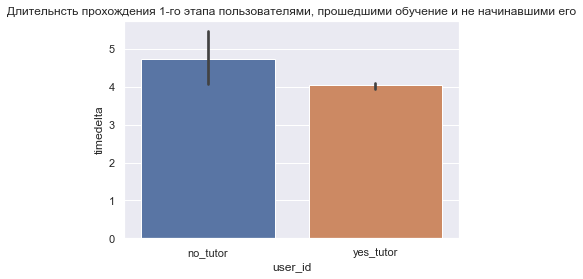

In [8]:
merge_not_started_df1['user_id']='no_tutor'
merge_finished_df1['user_id']='yes_tutor'
common_1=pd.concat([merge_not_started_df1,merge_finished_df1],sort=False)
common_1=common_1.reset_index(drop=True)
common_1['timedelta']=common_1['timedelta'].astype('timedelta64[h]')#выделяем из timedelta часы h 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.barplot(x='user_id', y='timedelta', data=common_1)
plt.title('Длительнсть прохождения 1-го этапа пользователями, прошедшими обучение и не начинавшими его')


### График, визуализирующий длительность прохождения 2-го этапа пользователями, прошедшими обучение и не начинавшими его

Text(0.5, 1.0, 'Длительность прохождения 2-го этапа пользователями, прошедшими обучение и не  начинавшими его')

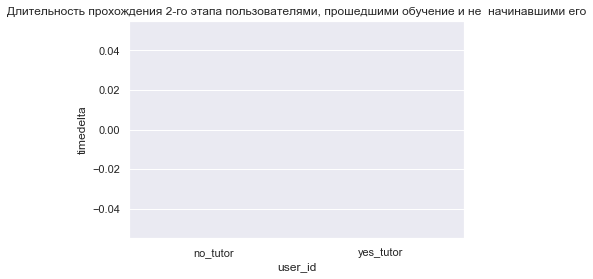

In [9]:
merge_not_started_df2['user_id']='no_tutor'
merge_finished_df2['user_id']='yes_tutor'
common_2=pd.concat([merge_not_started_df2,merge_finished_df2],sort=False)
common_2=common_2.reset_index(drop=True)
common_2['timedelta']=common_2['timedelta'].astype('timedelta64[h]')#выделяем из Timedelta часы h
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.barplot(x='user_id', y='timedelta', data=common_2)
plt.title('Длительность прохождения 2-го этапа пользователями, прошедшими обучение и не  начинавшими его')
#на данном графике пусто, т.к. 2-й этап составляет секунды, а на графике время отражено в часах

### График, визуализирующий длительность прохождения 3-го этапа пользователями, прошедшими обучение и не начинавшими его

Text(0.5, 1.0, 'Длительность прохождения 3-го этапа игры, пользователями, проходившими обучение и не проходившими его')

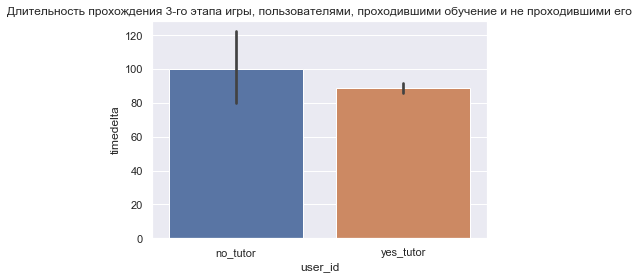

In [10]:
merge_not_started_df3['user_id']='no_tutor'
merge_finished_df3['user_id']='yes_tutor'
common_3=pd.concat([merge_not_started_df3, merge_finished_df3], sort=False)
common_3=common_3.reset_index(drop=True)
common_3['timedelta']=common_3['timedelta'].astype('timedelta64[h]')#выделяем из timedelta часы h
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.barplot(x='user_id', y='timedelta', data=common_3)
plt.title('Длительность прохождения 3-го этапа игры, пользователями, проходившими обучение и не проходившими его')

### График, отражающий все этапы прохождения игры для 2-х групп пользователей

*Данный график отражает наибольший вклад 3-го этапа во всю продолжительность прохождения игры, а также наибольшую продолжительность 3-го этапа у группы пользователей не прошедших обучение*

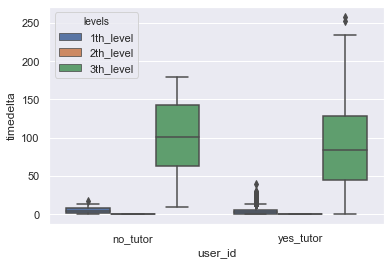

In [11]:
common_1['levels']='1th_level'
common_2['levels']='2th_level'
common_3['levels']='3th_level'
common_table=pd.concat([common_1, common_2, common_3])
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.boxplot(x='user_id', y='timedelta', data=common_table, hue='levels')


# Задача 2
## Выяснить, как часто пользователи начинают обучение после того, как они выбрали уровень сложности

..для понимания насколько прозрачен процесс взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.

Для этого нам необходимо вывести все уникальные пользовательские пути и определить как часто в них встречается возврат к этапу обучения (не только после этапа выбора уровня сложности)


In [12]:
#добавляем в таблицу purchases_18 столбец event_type со значением purchase, чтобы при
#склеивании с таблицей events_18 в столбце event_type были значения purchase как идентификатор оплаты, что необходимо для
#дальнейшего анализа путей прохождения пользователей внутри игры
purchases_18['event_type']='purchase'
events_18=events_18.rename(columns={'id':'event_id'})
purchases_18=purchases_18.rename(columns={'id':'purchases_id'})
#склеиваем таблицы
common_table=pd.concat([events_18, purchases_18], sort=False)
#переустанавливаем индексы и сортируем по времени все события,чтобы они шли в порядке в котором пользователи их выбирали
common_table=common_table.reset_index(drop=True).sort_values('start_time')
#группируем все типы событий event_type по пользователям user_id, которые их совершили и складываем в список
list_of_ways=common_table.groupby(['user_id'])['event_type'].apply(list).reset_index()
list_of_ways['event_path'] = list_of_ways['event_type'].apply(lambda x: ' > '.join(str(x) for x in x))
#выводим уникальные пути пользователей в игре и кол-во пользователей, идущих по этим путям
groups_of_way=list_of_ways.groupby(['event_path'])['user_id'].nunique().sort_values(ascending=False)
#выводим кол-во пользователей, которые выбирают этап старта обучения после этапа выбора уровня сложности
ways_l_t=groups_of_way[groups_of_way.index.str.contains('level_choice > tutorial_start')]
#выводим кол-во пользователей, которые выбирают этап старта обучения после этапа окончания обучения
ways_f_s=groups_of_way[groups_of_way.index.str.contains('tutorial_finish > tutorial_start')]
#выводим кол-во пользователей, которые выбирают этап старта обучения после незаконченного этапа обучения
ways_s_s=groups_of_way[groups_of_way.index.str.contains('tutorial_start > tutorial_start')]
#выводим кол-во пользователей, которые выбирают этап старта обучения после этапа выбора пакета бесплатных вопросов
ways_pack_s=groups_of_way[groups_of_way.index.str.contains('pack_choice > tutorial_start')]
#выводим кол-во пользователей, которые выбирают этап старта обучения после этапа покупки пакета платных вопросов
ways_pur_s=groups_of_way[groups_of_way.index.str.contains('purchase > tutorial_start')]
#считаем всех пользователей, которые начинали старт обучения хоть раз(пусть и не закончили его)
users_with_tutorstart=events_18[events_18.event_type=='tutorial_start'].user_id.nunique()
print('Из', users_with_tutorstart, 'пользователей, имеющих tutorial_start', sum(ways_l_t), 'пользователей начинают обучение после того как они выбрали уровень сложности \n', sum(ways_f_s), 'пользователей начинают повторное обучение после его окончания\n', sum(ways_s_s), 'пользователей начинают повторное обучение после незаконченного предыдущего \n', sum(ways_pack_s), 'пользователей начинают обучение после выбора пакета бесплатных вопросов \n', sum(ways_pur_s), 'пользователей начинают повторное обучение после оплаты пакета платных вопросов\n')


Из 11858 пользователей, имеющих tutorial_start 490 пользователей начинают обучение после того как они выбрали уровень сложности 
 1776 пользователей начинают повторное обучение после его окончания
 851 пользователей начинают повторное обучение после незаконченного предыдущего 
 903 пользователей начинают обучение после выбора пакета бесплатных вопросов 
 0 пользователей начинают повторное обучение после оплаты пакета платных вопросов



**Выводы** 

Т.к. многие пользователи (4020 пользователей из 11858 *а это на минуточку почти треть пользователей от всех,кто так или иначе начинал процесс обучения*) в процессе прохождения игры возвращаются к этапу прохождения обучения, значит работа с приложением не совсем понятна.
Мы видим из данных, что бо́льшая часть пользователей, возвращающихся к процессу обучения - это группа пользователей сразу возвращающаяся к началу обучения после его окончания, видимо сам раздел обучения написан не совсем доступным языком, поэтому нам необходимо его оптимизировать.


# Задача 3
## Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь

In [13]:
#выделяем пользователей, которые начинали или завершали обучение
tutors_18=events_18[(events_18.event_type=='tutorial_start')|(events_18.event_type=='tutorial_finish')].user_id.unique()
#отражаем все действия этих пользователей
tutors=events_18[events_18.user_id.isin(tutors_18)].reset_index(drop=True)
tutors = tutors.dropna(axis='index', how='any', subset=['tutorial_id'])
#считаем кол-во обучений (законченных или нет) для каждого пользователя
tutors_amount=tutors.pivot_table(values=['tutorial_id'],
                    index=['user_id'],
                    aggfunc='nunique')
#преобразуем в датафрейм, для последующего возможного объединения 2-х датафреймов
tutors_amount=tutors_amount['tutorial_id'].to_frame()
#считаем кол-во оплат для каждого пользователя
purchases_amount=purchases_18.pivot_table(values=['purchases_id'],
                    index=['user_id'],
                    aggfunc='nunique')
#преобразуем в датафрейм, для последующего возможного объединения 2-х датафреймов
purchases_amount=purchases_amount['purchases_id'].to_frame()
#объединяем 2 датафрейма, отражая пользователей, осуществивших оплату n-ое кол-во раз, прошедших обучение n-ое кол-во раз
pur_tut_amount=tutors_amount.merge(purchases_amount, on='user_id', how='inner')
#объединяем с purchases_18 для отображения оплаты amount
total_table=pur_tut_amount.merge(purchases_18, on='user_id', how='inner')
#отражаем только нужные нам данные, переименовываем столбцы
total_table=total_table[['user_id', 'tutorial_id', 'purchases_id_x', 'amount']].rename(columns={'purchases_id_x':'purchases_id'})
#определяем уникальные значения кол-в обучений tutorial_id
tutor_values=total_table.tutorial_id.unique()
#определяем средний платеж пользователей, прошедших обучений 1,2,3,4,5,6,7,8,9 раз соответственно
avg_1=total_table[total_table.tutorial_id==1].amount.mean()
avg_2=total_table[total_table.tutorial_id==2].amount.mean()
avg_3=total_table[total_table.tutorial_id==3].amount.mean()
avg_4=total_table[total_table.tutorial_id==4].amount.mean()
avg_5=total_table[total_table.tutorial_id==5].amount.mean()
avg_6=total_table[total_table.tutorial_id==6].amount.mean()
avg_7=total_table[total_table.tutorial_id==7].amount.mean()
avg_8=total_table[total_table.tutorial_id==8].amount.mean()
avg_9=total_table[total_table.tutorial_id==9].amount.mean()
print('\033[1m'+'Средний платеж пользователей, прошедших обучение 1,2,3,4,5,6,7,8,9 раз соответственно: \n'+'\033[0m', avg_1 ,'\n', avg_2,'\n', avg_3,'\n', avg_4,'\n', avg_5,'\n', avg_6,'\n', avg_7,'\n', avg_8,'\n', avg_9,'\n')
print('\033[1m'+' Таб.1 Количество обучений и платежей, осуществленных пользователями, имеющих этап обучения \n'+'\033[0m')
total_table


Средний платеж пользователей, прошедших обучение 1,2,3,4,5,6,7,8,9 раз соответственно: 
 109.75559237779619 
 114.44954128440367 
 111.27450980392157 
 98.33333333333333 
 121.875 
 119.64285714285714 
 110.41666666666667 
 103.84615384615384 
 117.6470588235294 

 Таб.1 Количество обучений и платежей, осуществленных пользователями, имеющих этап обучения 



,user_id,tutorial_id,purchases_id,amount
0,27845,2,1,100
1,27865,1,1,250
2,27884,3,1,150
3,27910,1,1,100
4,27911,1,1,50
...,...,...,...,...
1573,47671,1,1,200
1574,47687,1,1,100
1575,47712,1,1,50
1576,47732,1,1,150


Как видно из приведенной выше таблицы 1578 платящих пользователей из общего их количества 1600 проходят обучение(начинают и не завершают либо завершают), количество обучений варьируется от 1 до 9, количество платежей по 1 у каждого пользователя.

**Выводы:**
1. Сам факт прохождение обучения положительно влияет на осуществление платежа, поэтому **зависимость между прохождением обучения и вероятностью оплаты вопросов СУЩЕСТВУЕТ**
2. Количество пройденных обучений не влияет на количество платежей
3. Между количеством обучений и средним чеком нет устойчивой корреляции

### Круговая диаграмма, отражающая зависимость кол-ва пройденных обучений от кол-ва оплат

Text(0.5, 1.0, 'Процент оплат для группы пользователей в зависимости от количества обучений')

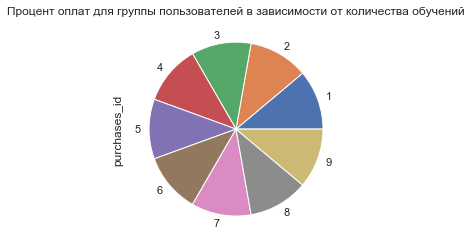

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
total_table['purchases_id']='purchase'
total_table.groupby(['tutorial_id'])['purchases_id'].nunique().plot.pie()
plt.title('Процент оплат для группы пользователей в зависимости от количества обучений')

# Задача 4 (самопоставленная)
## Выявить, существует ли зависимость между выбранным уровнем обучения и вероятностью оплаты

In [15]:
#выделяем пользователей, выбравших уровень обучения easy
easy_level_users=events_18[events_18.selected_level=='easy'].user_id.unique()
#подсчитываем кол-во пользователей с уровнем обучения easy, оплативших пакет вопросов
easy_choice=purchases_18[purchases_18.user_id.isin(easy_level_users)].user_id.nunique()
#подсчитываем средний чек этих пользователей
easy_avg_recipe=purchases_18[purchases_18.user_id.isin(easy_level_users)].amount.mean()
#выделяем пользователей, выбравших уровень обучения medium
medium_level_users=events_18[events_18.selected_level=='medium'].user_id.unique()
#подсчитываем кол-во пользователей с уровнем обучения medium, оплативших пакет вопросов
medium_choice=purchases_18[purchases_18.user_id.isin(medium_level_users)].user_id.nunique()
#подсчитываем средний чек этих пользователей
medium_avg_recipe=purchases_18[purchases_18.user_id.isin(medium_level_users)].amount.mean()
#выделяем пользователей, выбравших уровень обучения hard
hard_level_users=events_18[events_18.selected_level=='hard'].user_id.unique()
#подсчитываем кол-во пользователей с уровнем обучения hard, оплативших пакет вопросов
hard_choice=purchases_18[purchases_18.user_id.isin(hard_level_users)].user_id.nunique()
#подсчитываем средний чек этих пользователей
hard_avg_recipe=purchases_18[purchases_18.user_id.isin(hard_level_users)].amount.mean()
print('Кол-во платящих пользователей, выбравших уровень easy:', easy_choice,'и их средний чек:', easy_avg_recipe,'\n', 'Кол-во платящих пользователей, выбравших уровень medium:', medium_choice,'и их средний чек:', medium_avg_recipe,'\n', 'Кол-во платящих пользователей, выбравших уровень hard:', hard_choice, 'и их средний чек:', hard_avg_recipe)


Кол-во платящих пользователей, выбравших уровень easy: 189 и их средний чек: 114.94708994708995 
 Кол-во платящих пользователей, выбравших уровень medium: 969 и их средний чек: 109.52012383900929 
 Кол-во платящих пользователей, выбравших уровень hard: 442 и их средний чек: 111.59502262443439


 **Вывод:** наибольшее кол-во пользователей, купивших платные пакеты - это пользователи выбравшие уровень medium (средней сложности). Существенной разницы в среднем чеке не наблюдается.

Вполне вероятно, что выпросы уровня easy не заинтересовывают для осуществления покупки пакета платных вопросов и игра кажется не цепляющей, вовлеченность пользоватей маленькая, а на уровне hard вопросы слишком трудные, что возможно демотивирует многих пользователей.

Сл-но команде необходимо оптимизировать именно этих 2 уровня:

-*hard-уровень*

Возможно целесообразным будет миксовать на hard-уровне степень сложности вопросов(70 % вопросов-hard уровня, 30%-уровня medium(или просто чуть менее сложные) и при неправильном ответе на вопрос из категории 70% тут же давать менее сложный вопрос,чтобы предыдущий неправильно отвеченный подзадоривал, а последующий менее сложный не давал сдаться(дразнить надо,люди любят это), а также добавить мотивационного контента ("каждый неправильный твой ответ-это новое знание в копилку", "нету глупых людей, есть неинтересующиеся и здающиеся", "не знал ответа? мой бывший не знал слова 'картон', ему было 20"

-*easy-уровень*

Возможно целесообразным будет пересмотреть степень легкости вопросов и чуть усложнить данный уровень



